In [ ]:
#

In [73]:
#this is the most basic model
#importing the dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('Advertising.csv')
print(data.isna().sum())

X = data[['TV', 'Radio', 'Newspaper']].values
y = data['Sales'].values.reshape(-1, 1)

TV = X[:, 0].reshape(-1, 1)
Radio = X[:, 1].reshape(-1, 1)
Newspaper = X[:, 2].reshape(-1, 1)


X_poly = np.hstack([
    TV,
    Radio,
    Newspaper,
    TV**2,
    Radio**2,
    Newspaper**2,
    TV*Radio,
    TV*Newspaper,
    Radio*Newspaper
])
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

#calculating mean and std for normalization

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

#normalizing the data
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std




Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64


In [46]:
#adding the bias term

#import numpy as np

#expanded_X = np.ones((X.shape[0], 1))
#X_b = np.c_[expanded_X, X]
#X_b will have the bias term added to the features


In [86]:
#coding the  linear regression model from scratch
#will apply early stopping now

class LinearRegression:

    def __init__(self, learn_rate = 1e-7, iter = 50000, method = 'batch', batch_size = 32, l1_reg = 0.0, early_stopping=False, patience=1000):
        self.l1_reg = l1_reg
        self.method = method
        self.batch_size = batch_size
        self.lr = float(learn_rate)
        self.iter = int(iter)
        self.weights = None
        self.early_stopping = early_stopping
        self.patience = patience
        self.loss_history = []

    def fit(self, X, y):
        m, n = X.shape
        #m -- no of samples (north to south)
        #n -- no of features (west to east)

        self.weights = np.zeros((n, 1))
        #initializing weights to zero including bias term
        self.bias = 0


        for _ in range(self.iter):
            if self.method == 'batch':

                y_pred = X @ self.weights + self.bias
                error = y_pred - y
                loss = (1/(2*m)) * np.sum(error ** 2) + (self.l1_reg/2) * np.sum(np.abs(self.weights))

                grad_w = (1/m) * (X.T @ error) + self.l1_reg * np.sign(self.weights)
                grad_b = (1/m) * np.sum(error)
                #loss gradients wrt to weights and bias

                self.weights -= self.lr * grad_w
                self.bias -= self.lr * grad_b

            elif self.method == 'stochastic':
                for i in range(m):
                    xi = X[i].reshape(1, -1)
                    yi = y[i].reshape(1, -1)
                    y_pred = xi @ self.weights + self.bias
                    error = y_pred - yi

                    gradient_w = xi.T @ error
                    gradient_b = error.item()

                    self.weights -= self.lr * gradient_w
                    self.bias -= self.lr * gradient_b

                y_pred = X @ self.weights + self.bias
                loss = (1/(2*m)) * np.sum((y_pred - y) ** 2) + (self.l1_reg/2) * np.sum(np.abs(self.weights))
                #this is the loss after one epoch

            elif self.method == 'mini-batch':
                premu = np.random.permutation(m)
                X_Shuffle = X[premu]
                y_Shuffle = y[premu]

                for start in range(0, m, self.batch_size):
                    end = start + self.batch_size
                    xb = X_Shuffle[start:end]
                    yb = y_Shuffle[start:end]

                    y_pred = xb @ self.weights + self.bias
                    error = y_pred - yb

                    gradient_w = (1/self.batch_size) * (xb.T @ error)
                    gradient_b = (1/self.batch_size) * np.sum(error)

                    self.weights -= self.lr * gradient_w
                    self.bias -= self.lr * gradient_b
                
                #calculating loss after one epoch
                y_pred  = X @self.weights + self.bias
                error = y_pred - y
                loss = (1/(2*m)) * np.sum(error ** 2) + (self.l1_reg/2) * np.sum(np.abs(self.weights))

        
            self.loss_history.append(loss)

            #early stopping implementation
            if self.early_stopping and _ > 0:
                if loss > self.loss_history[-2]:
                    if _ - self.loss_history.index(min(self.loss_history)) >= self.patience:
                        print(f"Early stopping at iteration {_} with loss {loss}")
                        break

           
            if _ % 5000 == 0:
                print(f"Loss at iteration {_}: {loss}")

    def predict(self, X):
        return X @ self.weights + self.bias
    
    



            


In [93]:
#applying cross validation to choose best hyperparameters
from sklearn.model_selection import KFold
import numpy as np

def cross_validation_score_customisation(X, y, k=5):

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    r2_scores = []

    fold = 1
    for train_indx, val_indx in kf.split(X):
        X_training, X_validation = X[train_indx], X[val_indx]
        y_training, y_validation = y[train_indx], y[val_indx]

        #normalizing the data
        X_mean = X_training.mean(axis=0)
        X_std = X_training.std(axis=0)

        X_training_normalised = (X_training - X_mean) / X_std
        X_validation_normalised = (X_validation - X_mean) / X_std

        y_training_mean = y_training.mean()
        y_training_std = y_training.std()

        y_training_normalised = (y_training - y_training_mean) / y_training_std
        y_validation_normalised = (y_validation - y_training_mean) / y_training_std

        model = LinearRegression(learn_rate=0.01, iter=50000, method='batch', l1_reg=0.0, early_stopping=True, patience=1000)
        model.fit(X_training_normalised, y_training_normalised)
        y_val_pred = model.predict(X_validation_normalised)


        #calculating r2 score
        ss_total = np.sum((y_validation_normalised - 0) ** 2)
        ss_residual = np.sum((y_validation_normalised - y_val_pred) ** 2)
        r2_score = 1 - (ss_residual / ss_total)

        r2_scores.append(r2_score)
        print(f"Fold {fold} R2 Score: {r2_score:.4f}")
        fold += 1

        print(f"Average R2 Score across {k} folds: {np.mean(r2_scores):.4f}")
    return np.mean(r2_scores)


Loss at iteration 0: 0.5000000000000001
Loss at iteration 5000: 0.007689881743764112
Loss at iteration 10000: 0.006989705989578885
Loss at iteration 15000: 0.00695027307329325
Loss at iteration 20000: 0.006947898629311751
Loss at iteration 25000: 0.006947750749109434
Loss at iteration 30000: 0.006947741271841746
Loss at iteration 35000: 0.00694774064874973
Loss at iteration 40000: 0.006947740606871123
Loss at iteration 45000: 0.006947740604004622
Fold 1 R2 Score: 0.9870
Average R2 Score across 5 folds: 0.9870
Loss at iteration 0: 0.5
Loss at iteration 5000: 0.007413817530520523
Loss at iteration 10000: 0.006803663003087679
Loss at iteration 15000: 0.006768762491713116
Loss at iteration 20000: 0.006766639897871996
Loss at iteration 25000: 0.006766508879595879
Loss at iteration 30000: 0.006766500756556786
Loss at iteration 35000: 0.006766500252060906
Loss at iteration 40000: 0.006766500220700695
Loss at iteration 45000: 0.006766500218750283
Fold 2 R2 Score: 0.9860
Average R2 Score across

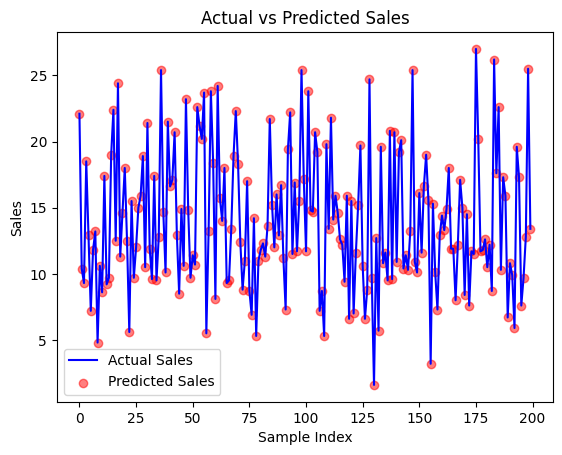

In [98]:
scores = cross_validation_score_customisation(X_poly, y, k=5)
print(f"Cross-validated R2 Score: {scores:.4f}")

#plotting the k-fold results
import matplotlib.pyplot as plt

print(X_poly.shape)
print(y.shape)

#they have different shapes so we cannot plot them directly
#we need to reshape y to be compatible with X_poly for plotting
y_reshaped = y.flatten()

#ploting the k-fold results
plt.plot(range(len(y_reshaped)), y_reshaped, label='Actual Sales', color='blue')
plt.scatter(range(len(y_reshaped)), y_reshaped, label='Predicted Sales', color='red', alpha=0.5 )
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

Loss at iteration 0: 0.49999999999999983
Loss at iteration 5000: 0.07141533218904708
Loss at iteration 10000: 0.07145543979123073
Loss at iteration 15000: 0.071420163081333
Loss at iteration 20000: 0.07136202751948267
Loss at iteration 25000: 0.07142164650332272
Loss at iteration 30000: 0.07130587031901772
Loss at iteration 35000: 0.0714030518820292
Loss at iteration 40000: 0.07134685635484242
Loss at iteration 45000: 0.07130973429793122
TV          :0.1963
Radio       :0.0008
Newspaper   :0.0008
TV * Radio  :0.0014
Radio^2     :0.0007
Bias:  1.6758122667326727e-16
Mean Squared Error: 0.050595790198221566
Root Mean Squared Error: 0.22493507996357875
Mean Absolute Error: 0.15327988576577836
R^2 Score on test set: 0.958424725843247
R^2 Score on training set: 0.950938035826986


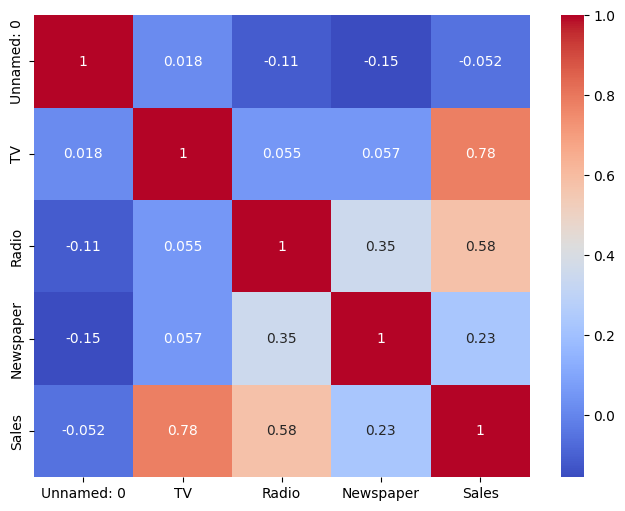

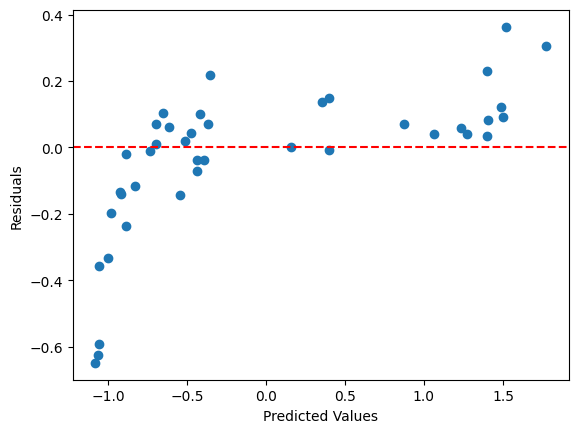

In [87]:
model = LinearRegression(learn_rate= 0.02, iter=50000, method='batch', l1_reg=0.1)
model.fit(X_train, y_train)

feature_nums = [
    "TV",
    "Radio",
    "Newspaper",
    "TV * Radio",
    "Radio^2"
]

for name , w in zip(feature_nums, model.weights.flatten()):
    print(f"{name:12s}:{w:.4f}")

print("Bias: ", model.bias)

predictions_on_test = model.predict(X_test)

train_predictions = model.predict(X_train)


mse = np.mean((predictions_on_test - y_test) ** 2)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


mae = np.mean(np.abs(predictions_on_test - y_test))
print("Mean Absolute Error:", mae)

ss_res = np.sum((y_test - predictions_on_test) ** 2)
sst_tot = np.sum((y_test - np.mean(y_test))** 2 )
r2_score = 1 - (ss_res / sst_tot)
print("R^2 Score on test set:", r2_score)

#r2 score on training set
ss_res_train = np.sum((y_train - train_predictions) ** 2)
sst_tot_train = np.sum((y_train - np.mean(y_train))** 2 )
r2_score_train = 1 - (ss_res_train / sst_tot_train)
print("R^2 Score on training set:", r2_score_train)

#making a correlation matrix 

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#doing a residual analysis
residual = y_test - predictions_on_test
plt.scatter(predictions_on_test, residual)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()




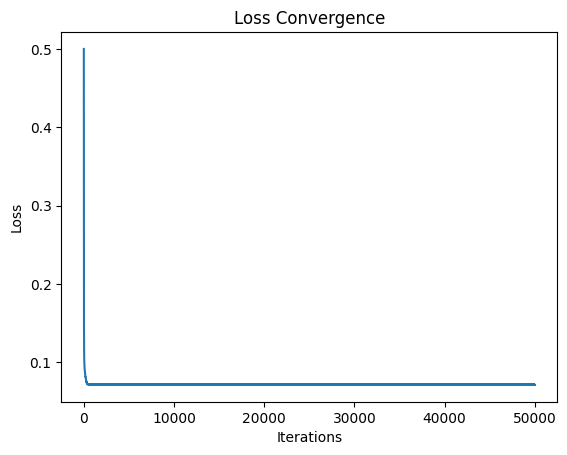

In [88]:
import matplotlib.pyplot as plt

plt.plot(model.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.show()


In [89]:
#examining stochastic gradient descent
model_sgd = LinearRegression(learn_rate= 0.01, iter=50, method='stochastic', l1_reg=0.2)
model_sgd.fit(X_train, y_train)
predictions_on_test = model_sgd.predict(X_test)

prediction_on_train = model_sgd.predict(X_train)

mse_on_sgd = np.mean((predictions_on_test - y_test) ** 2)
print("Mean Squared Error with SGD:", mse_on_sgd)

mae_on_sgd = np.mean(np.abs(predictions_on_test - y_test))
print("Mean Absolute Error with SGD:", mae_on_sgd)

rmse_on_sgd = np.sqrt(mse_on_sgd)
print("Root Mean Squared Error with SGD:", rmse_on_sgd)

ss_res_sgd = np.sum((y_test - predictions_on_test) ** 2)
sst_tot_sgd = np.sum((y_test - np.mean(y_test))** 2)
r2_score_on_sgd = 1 - (ss_res_sgd / sst_tot_sgd)
print("R^2 Score on test set with SGD:", r2_score_on_sgd)

ss_res_train_sgd = np.sum((y_train - prediction_on_train) ** 2)
sst_tot_train_sgd = np.sum((y_train - np.mean(y_train))**2)
r2_score_train_sgd = 1 - (ss_res_train_sgd / sst_tot_train_sgd)
print("R^2 Score on training set with SGD:", r2_score_train_sgd)

                           
                     

Loss at iteration 0: 0.16690690672817432
Mean Squared Error with SGD: 0.01827396878994053
Mean Absolute Error with SGD: 0.11180636071639252
Root Mean Squared Error with SGD: 0.13518124422396965
R^2 Score on test set with SGD: 0.9849840222003208
R^2 Score on training set with SGD: 0.9848117061887512


In [90]:
#examining mini-batch gradient descent
model_mini = LinearRegression(learn_rate= 0.01, iter=1000, method='mini-batch', batch_size=16, l1_reg=0.15)
model_mini.fit(X_train, y_train)
predictions_on_test = model_mini.predict(X_test)

prediction_on_train = model_mini.predict(X_train)

mse_on_mini_train = np.mean((prediction_on_train - y_train)**2)
print("Mean Squared Error with Mini-Batch GD:", mse_on_mini_train)

rmse_on_mini_train = np.sqrt(mse_on_mini_train)
print("Root Mean Squared Error with Mini-Batch GD:", rmse_on_mini_train)

mae_on_mini_train = np.mean(np.abs(prediction_on_train - y_train))
print("Mean Absolute Error with Mini-Batch GD:", mae_on_mini_train)

ss_res_mini_train = np.sum((y_train - prediction_on_train) ** 2)
sst_tot_mini_train = np.sum((y_train - np.mean(y_train))**2)
r2_score_on_mini_train = 1 - (ss_res_mini_train / sst_tot_mini_train)
print("R^2 Score on training set with Mini-Batch GD:", r2_score_on_mini_train)

mse_on_mini_test = np.mean((predictions_on_test - y_test) ** 2) 
print("Mean Squared Error on test set with Mini-Batch GD:", mse_on_mini_test)

rmse_on_mini_test = np.sqrt(mse_on_mini_test)
print("Root Mean Squared Error on test set with Mini-Batch GD:", rmse_on_mini_test)

mae_on_mini_test = np.mean(np.abs(predictions_on_test - y_test))
print("Mean Absolute Error on test set with Mini-Batch GD:", mae_on_mini_test)

ss_res_mini_test = np.sum((y_test - predictions_on_test)** 2)
ss_tot_mini_test = np.sum((y_test - np.mean(y_test))**2)
r2_score_on_mini_test = 1 - (ss_res_mini_test / ss_tot_mini_test)
print("R^2 Score on test set with Mini-Batch GD:", r2_score_on_mini_test)   


Loss at iteration 0: 0.2939532221140655
Mean Squared Error with Mini-Batch GD: 0.013978799185635129
Root Mean Squared Error with Mini-Batch GD: 0.11823197192652725
Mean Absolute Error with Mini-Batch GD: 0.07866936093789043
R^2 Score on training set with Mini-Batch GD: 0.9860212008143648
Mean Squared Error on test set with Mini-Batch GD: 0.015322623717521733
Root Mean Squared Error on test set with Mini-Batch GD: 0.12378458594478448
Mean Absolute Error on test set with Mini-Batch GD: 0.10109089526801877
R^2 Score on test set with Mini-Batch GD: 0.9874091840573898
